# Installing Dependencies

In [56]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns


# Data Loading

In [57]:
# Load the dataset
file_path = 'yelp_review_cleaned_dataset.csv'
df = pd.read_csv(file_path)

# Limit the size of the dataset
df = df.sample(n=5000, random_state=42)

# Add a column for fake reviews with a random distribution
np.random.seed(42)
df['is_fake'] = np.random.choice([0, 1], size=len(df), p=[0.9, 0.1])
# Display basic information about the dataset
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 6252 to 2764
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_id     5000 non-null   object
 1   user_id       5000 non-null   object
 2   business_id   5000 non-null   object
 3   stars         5000 non-null   int64 
 4   useful        5000 non-null   int64 
 5   funny         5000 non-null   int64 
 6   cool          5000 non-null   int64 
 7   text          5000 non-null   object
 8   date          5000 non-null   object
 9   cleaned_text  5000 non-null   object
 10  is_fake       5000 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 468.8+ KB


(None,
                    review_id                 user_id             business_id  \
 6252  DXZtkvp3zgHfwOyQ8He0jQ  gatM0_LzUSqNEmlQcBPiBQ  bXjnfT69E8DJinX-ifOofA   
 4684  BRmDLZSJH_YLsbpJ9_VC6Q  dQIgI_eyox_Q4qK0T6iKmA  jLDwSeoQ_kDQwhnUJQO2yw   
 1731  34ZT45dZD_JXbU5rvuyJgg  0xapSfoASxW3pozvAK_DIQ  4nSnvxK-4lKwZvXDGYK5Uw   
 4742  nHwzviHqA97g7341VT2aWw  _GW_i-3PFWZNMjLc_YMXpw  0hIXH9jMdHov1VrLC8ujUg   
 4521  DAe6ffProBgui30TGuFF4g  tGlcQt6syMPeIGKFUXOlmg  1JtpcHELRrSDoWS80WtzuQ   
 
       stars  useful  funny  cool  \
 6252      1       0      0     0   
 4684      3       1      0     0   
 1731      4       3      0     1   
 4742      5       0      0     0   
 4521      5       2      0     0   
 
                                                    text                 date  \
 6252  I can not believe on how unprofessional we wer...  2018-06-19 20:32:28   
 4684  Before one thing got under my skin, I would sa...  2016-07-05 00:10:57   
 1731  This location has been newly re

# Data Statistics


In [58]:
# Preprocess the cleaned text data
vectorizer = TfidfVectorizer(max_features=300)
text_embeddings = vectorizer.fit_transform(df['cleaned_text']).toarray()

# Encode user_id and business_id
user_encoder = LabelEncoder()
business_encoder = LabelEncoder()
df['user_id_encoded'] = user_encoder.fit_transform(df['user_id'])
df['business_id_encoded'] = business_encoder.fit_transform(df['business_id'])

# Number of reviews, users, and businesses
num_reviews = df.shape[0]
num_users = df['user_id_encoded'].nunique()
num_businesses = df['business_id_encoded'].nunique()

# Create a feature matrix for reviews
review_features = torch.tensor(text_embeddings, dtype=torch.float)

# Create placeholder features for users and businesses
user_features = torch.zeros((num_users, review_features.shape[1]))
business_features = torch.zeros((num_businesses, review_features.shape[1]))

# Concatenate all features to create the final feature matrix
features = torch.cat([review_features, user_features, business_features], dim=0)

# Display the encoded IDs and features
print(df[['user_id_encoded', 'business_id_encoded']].head())
print(features.shape)
print(f'Number of reviews: {num_reviews}')
print(f'Number of users: {num_users}')
print(f'Number of businesses: {num_businesses}')


      user_id_encoded  business_id_encoded
6252             3391                 1583
4684             3144                 1910
1731              168                  251
4742             2808                   73
4521             4377                  102
torch.Size([12470, 300])
Number of reviews: 5000
Number of users: 4894
Number of businesses: 2576


In [59]:
# Correctly calculate the total number of nodes
total_nodes = num_reviews + num_users + num_businesses

# Create edge index (connections between nodes)
user_edges = []
business_edges = []

# Create user edges
for idx, row in df.iterrows():
    user_edge = num_reviews + row['user_id_encoded']
    if user_edge < total_nodes:
        user_edges.append([idx, user_edge])
    else:
        raise ValueError(f"User edge index out of bounds: {user_edge}")

# Create business edges
for idx, row in df.iterrows():
    business_edge = num_reviews + num_users + row['business_id_encoded']
    if business_edge < total_nodes:
        business_edges.append([idx, business_edge])
    else:
        raise ValueError(f"Business edge index out of bounds: {business_edge}")

# Combine edges
edges = torch.tensor(user_edges + business_edges, dtype=torch.long).t().contiguous()

# Ensure the edges do not go out of bounds
if edges.max().item() >= total_nodes:
    raise ValueError(f"Edge index out of bounds: {edges.max().item()} >= {total_nodes}")

# Create PyTorch Geometric data object
data = Data(x=features, edge_index=edges)

print(data)


Data(x=[12470, 300], edge_index=[2, 10000])


# Gnn Model

Epoch 0, Loss: 0.6937193274497986
Epoch 10, Loss: 0.3251044452190399
Epoch 20, Loss: 0.3387833535671234
Epoch 30, Loss: 0.31308233737945557
Epoch 40, Loss: 0.3093625009059906
Epoch 50, Loss: 0.30294954776763916
Epoch 60, Loss: 0.29803574085235596
Epoch 70, Loss: 0.29436489939689636
Epoch 80, Loss: 0.29106405377388
Epoch 90, Loss: 0.28843003511428833
Epoch 100, Loss: 0.286186158657074
Epoch 110, Loss: 0.2841939628124237
Epoch 120, Loss: 0.2822699248790741
Epoch 130, Loss: 0.2801889181137085
Epoch 140, Loss: 0.27740269899368286
Epoch 150, Loss: 0.27300724387168884
Epoch 160, Loss: 0.26618653535842896
Epoch 170, Loss: 0.25751182436943054
Epoch 180, Loss: 0.2479218691587448
Epoch 190, Loss: 0.23822520673274994
Test Loss: 0.38337528705596924


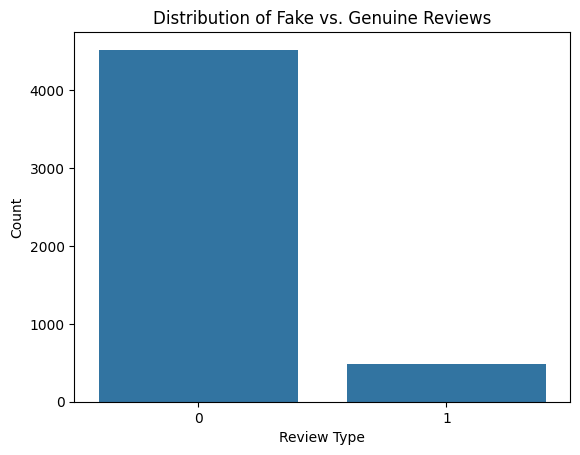

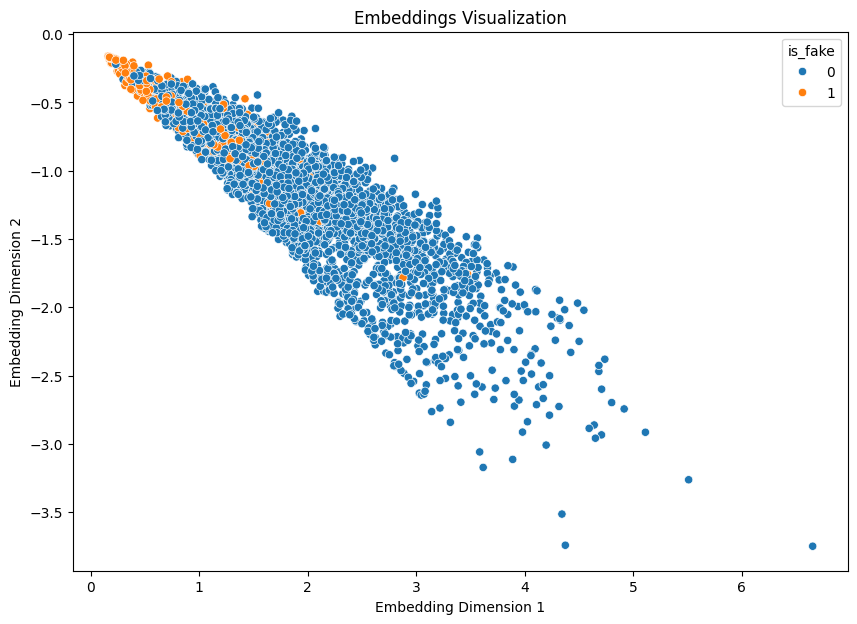

In [60]:
# Handle missing values by imputing the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
df['cleaned_text'] = imputer.fit_transform(df[['cleaned_text']]).ravel()

# Encode user_id and business_id on the entire dataset before splitting
user_encoder = LabelEncoder()
business_encoder = LabelEncoder()

df['user_id_encoded'] = user_encoder.fit_transform(df['user_id'])
df['business_id_encoded'] = business_encoder.fit_transform(df['business_id'])

# Now split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Use the already encoded IDs for further processing
train_user_ids = train_df['user_id_encoded'].values  # Use .values here
train_business_ids = train_df['business_id_encoded'].values  # Use .values here
test_user_ids = test_df['user_id_encoded'].values  # Use .values here
test_business_ids = test_df['business_id_encoded'].values  # Use .values here

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=300, stop_words='english')
train_text_embeddings = vectorizer.fit_transform(train_df['cleaned_text']).toarray()
test_text_embeddings = vectorizer.transform(test_df['cleaned_text']).toarray()

# Create a feature matrix for reviews
train_review_features = torch.tensor(train_text_embeddings, dtype=torch.float)
test_review_features = torch.tensor(test_text_embeddings, dtype=torch.float)

# Number of users and businesses
num_users = df['user_id_encoded'].nunique()
num_businesses = df['business_id_encoded'].nunique()

# Placeholder features for users and businesses (same as training)
user_features = torch.zeros((num_users, train_review_features.shape[1]))
business_features = torch.zeros((num_businesses, train_review_features.shape[1]))

# Concatenate all features to create the final feature matrix for training and testing
train_features = torch.cat([train_review_features, user_features, business_features], dim=0)
test_features = torch.cat([test_review_features, user_features, business_features], dim=0)

# Define the graph data structure
train_edges = torch.tensor([train_user_ids, train_business_ids + num_users], dtype=torch.long)
test_edges = torch.tensor([test_user_ids, test_business_ids + num_users], dtype=torch.long)

# Define graph data for training
train_data = Data(x=train_features, edge_index=train_edges)
test_data = Data(x=test_features, edge_index=test_edges)

#GNN MODEL
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(train_features.shape[1], hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)  # Output 2 classes for fake and genuine

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model, loss function, and optimizer
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(train_data)
    loss = criterion(out[:len(train_df)], torch.tensor(train_df['is_fake'].values, dtype=torch.long))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Model evaluation on test set
model.eval()
with torch.no_grad():
    test_out = model(test_data)
    test_loss = criterion(test_out[:len(test_df)], torch.tensor(test_df['is_fake'].values, dtype=torch.long))
    print(f'Test Loss: {test_loss.item()}')

# Generate embeddings for visualization
with torch.no_grad():
    embeddings = model(train_data).detach().numpy()

# Visualize the distribution of fake vs. genuine reviews
sns.countplot(x='is_fake', data=df)
plt.title('Distribution of Fake vs. Genuine Reviews')
plt.xlabel('Review Type')
plt.ylabel('Count')
plt.show()

# Visualize the embeddings
plt.figure(figsize=(10, 7))
sns.scatterplot(x=embeddings[:len(train_df), 0], y=embeddings[:len(train_df), 1], hue=train_df['is_fake'])
plt.title('Embeddings Visualization')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.show()

# Unsupervised Learning Metrics


In [61]:
# Evaluate using unsupervised learning metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

sil_score = silhouette_score(embeddings[:len(train_df)], train_df['is_fake'])
calinski_harabasz = calinski_harabasz_score(embeddings[:len(train_df)], train_df['is_fake'])
davies_bouldin = davies_bouldin_score(embeddings[:len(train_df)], train_df['is_fake'])

print(f'Silhouette Score: {sil_score}')
print(f'Calinski-Harabasz Index: {calinski_harabasz}')
print(f'Davies-Bouldin Index: {davies_bouldin}')

# Visualize the evaluation metrics
metrics = {
    'Silhouette Score': sil_score,
    'Calinski-Harabasz Index': calinski_harabasz,
    'Davies-Bouldin Index': davies_bouldin,
}

# Count the number of fake reviews identified
num_fake_reviews = df['is_fake'].sum()
print(f'Number of fake reviews: {num_fake_reviews}')

Silhouette Score: 0.1562269926071167
Calinski-Harabasz Index: 640.1426620806814
Davies-Bouldin Index: 1.0001174208365555
Number of fake reviews: 479


In [64]:
from sklearn.cluster import KMeans
# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings[:len(df)])

# Evaluate clustering
sil_score_kmeans = silhouette_score(embeddings[:len(df)], kmeans_labels)
calinski_harabasz_kmeans = calinski_harabasz_score(embeddings[:len(df)], kmeans_labels)
davies_bouldin_kmeans = davies_bouldin_score(embeddings[:len(df)], kmeans_labels)

print(f'K-Means Silhouette Score: {sil_score_kmeans}')
print(f'K-Means Calinski-Harabasz Index: {calinski_harabasz_kmeans}')
print(f'K-Means Davies-Bouldin Index: {davies_bouldin_kmeans}')
# Count the number of fake reviews identified
num_fake_reviews = df['is_fake'].sum()
print(f'Number of fake reviews: {num_fake_reviews}')


K-Means Silhouette Score: 0.5753334164619446
K-Means Calinski-Harabasz Index: 7975.605936229536
K-Means Davies-Bouldin Index: 0.6402792892444763
Number of fake reviews: 479
